The 2d advection diffusion equation with simple flux conditions
-----------

2 methods available:

1. **SLCN** *A Semi-Lagrangian Crank-Nicholson Algorithm for the Numerical Solution of Advection-Diffusion Problems, Spiegelman*, https://doi.org/10.1029/2005GC001073
2. **SUPG** A.N. Brooks, T.J.R. Hughes, *Strehmline upwind/Petrov-Galerkin formulations ...*, https://doi.org/10.1016/0045-7825(82)90071-8 

---------
Model:

2D Heat Equation run to steady state, $0 \leqslant x \leqslant 1 $ and $ y_{0}\leqslant y \leqslant y_{1}$ with Dirichlet BC at $ \Gamma_{D} $ and Neumman BC at $ \Gamma_{\phi} $.

\\[
\frac{\partial T}{\partial t} = -\mathbf{v} \cdot \nabla T +\nabla \cdot (k \nabla T)+h
\\]

with

\\[
\begin{align*}
T &= T_{D} &\quad\text{at  } \Gamma_{D} \\
\mathbf{n} \cdot k\nabla{T} &= \phi &\quad\text{at  } \Gamma_{\phi}
\end{align*}
\\]

$ \mathbf{n} $ is the unit normal **outward facing** vector, $ v, k, h, T_{D}, \phi $ are constants representing the velocity in y-axis, the diffusivity coefficient, the volumetric source term, prescribed values of T on portion $\Gamma_{D}$ and the normal diffusive flux on the portion $\Gamma_{\phi}$ respectively.

------
Letting

$ \frac{\partial T}{\partial x} = 0 $ 

and the equation run to steaty state, $ \frac{\partial T}{\partial t} = 0 $

the problem reduces to a 2nd order ode, described by the analytic function

$T = c_{0} \exp \left[\frac{v}{k}y\right] + \frac{h}{v}y + c_{1}$

where:

$c_{0} = ( \frac{\phi}{k}-\frac{h}{v} ) \cdot \frac{k}{v} \cdot \exp \left[-\frac{v}{k}y_{0} \right]$

$c_{1} = T_{D}-c_{0}\exp \left[\frac{v}{k}y_{1} \right] - \frac{h}{v}y_{1}$



We implement the above boundary conditions using: 
 * a `DirichletCondition` for $T=T_{D}$
 * a `NeumannCondition` object for $ \mathbf{n} \cdot k\nabla{T} = \phi $

When the `NeumannCondition` object is associated with the `AdvectionDiffusion` object it defines a flux along the boundary region $ \Gamma_{\phi}$:
  * $ \mathbf{n} \cdot k\nabla T  = \phi \quad $ at $ \Gamma_{\phi} $
  
    where:  
    * $\Gamma_{\phi}$ is the set of vertices to apply this conditions, eg, IndexSets along the surface of the domain,  
    * $ \mathbf{n} $ is the unit normal **outwards facing** from the surface.  
    * $ \phi $ is the scalar flux, i.e. $ k \nabla T $, along $\Gamma_{\phi}$.

---------------

An example: Defining a scalar field's flux at the bottom wall in a 2D rectangular domain.

The outward facing normal vector at the bottom wall $\mathbf{n}\mid_{(x,y_{0})}=\left[0,-1\right] $) and the imposed flux vector $k \nabla T = \left[0, \phi\right]$

The `NeumannCondition` object definition of this condition would be: 

```
nbc = uw.conditions.NeumannCondition( fn_flux= -1.0 * phi, variable=tField,
                                      indexSetsPerDof=mesh.specialSets["MinJ_VertexSet"] )
```

Applies a 'fn_flux' to the scalar 'variable' `MeshVariable` over the boundary vertices in the set 'indexSetsPerDof'. The factor -1 is from the vector multiplication with the outward facing normal vector.

Here `phi` can be a `underworld.Function` or `underworld.MeshVariable` type.

In [1]:
from __future__ import print_function

# model options - all are run, see below for 'model_run()'

# wall_setup_options = ('a',    # neumman top, dirichlet bottom
#                       'b')    # neumman bottom, dirichlet top

# method_options     = ('supg', # Stream line UPwind Galerkin method 
#                       'slcn') # Semi-Lagrangian Crank Nicholson method 

# parameters
TD = 8.0       # dirichlet temperature
k = 6.70       # diffusivity
h = 8.0        # source term
phi = 4        # boundary flux
v = 2.47       # j-axis velocity component

# y-axis extent
y0 = -0.6 ; y1 = 1.3

import underworld as uw
import underworld.visualisation as vis
from underworld import function as fn
import numpy as np

make_graphs = uw.utils.is_kernel() # flag for matplotlib output
try:
    import matplotlib
except ImportError:
    make_graphs=False
rank = uw.mpi.rank

In [2]:
# analytic solution definitions as underworld functions
c0 = fn.misc.constant(0.)
c1 = fn.misc.constant(0.)
fn_y = fn.input()[1]

# the analytic solution
fn_analyticT = c0*fn.math.exp(v/k*fn_y) + h/v*fn_y + c1
# the analytic gradient
fn_analytic_dT_dy = v/k*c0*fn.math.exp(v/k*fn_y) + h/v

In [3]:
def model_run(wall_setup='b', method_setup='slcn', rtol=1e-5, maxSteps=2000, elementType='Q1'):
    """
    This function sets up the described model and executes it.
    
    Parameters:
    
    wall_setup :
    ...
    
    Return value:
      (3-tuple) : Float values represent,
                  1) chosen timestep value. 
                  2) the number of iteration to reach the rtol,
                  3) the percentage error against the analytic solution   
    """ 

    mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"),   elementRes  = (10, 15), 
                                     minCoord    = (0., y0), maxCoord    = (1., y1))

    tField = mesh.add_variable( nodeDofCount=1, dataType='double')
    vField = mesh.add_variable( nodeDofCount=2, dataType='double')

    if wall_setup == 'a':
        ny = 1. # outward normal component in y
        c0.value = (phi/k-h/v) * k/v * np.exp(-v/k*y1)
        c1.value = TD - c0.value*np.exp(v/k*y0) - h/v*y0

        neumannIndex   = mesh.specialSets['MaxJ_VertexSet']
        dirichletIndex = mesh.specialSets['MinJ_VertexSet']
    else:
        ny = -1. # outward normal component in y
        c0.value = (phi/k-h/v) * k/v * np.exp(-v/k*y0)
        c1.value = TD - c0.value*np.exp(v/k*y1) - h/v*y1

        neumannIndex   = mesh.specialSets['MinJ_VertexSet']
        dirichletIndex = mesh.specialSets['MaxJ_VertexSet']

    # define neumann condition - flux, ny is the direction of the outward normal
    nbc = uw.conditions.NeumannCondition( fn_flux         = ny * phi, 
                                          variable        = tField, 
                                          indexSetsPerDof = (neumannIndex) )

    # flag top boundary nodes with dirichlet conditions
    bc = uw.conditions.DirichletCondition(variable = tField, indexSetsPerDof = (dirichletIndex) )

    # set entire tField to TD, including dirichlet 
    tField.data[:] = TD

    # set constant velocity field
    vField.data[:] = (0.0,v)

    # define heat eq. system
    factor_dt = 1.
    tDotField = None

    if method_setup == 'supg':
        tDotField = mesh.add_variable( nodeDofCount=1, dataType='double') # extra variable needed with supg
    elif method_setup == 'slcn':
        factor_dt = 5.
    else:
        raise ValueError("Can't process 'method_setup'")

    system = uw.systems.AdvectionDiffusion( phiField       = tField,
                                            phiDotField    = tDotField,
                                            method         = method_setup,
                                            velocityField  = vField,
                                            fn_diffusivity = k,
                                            fn_sourceTerm  = h,
                                            conditions     = [bc, nbc] )

    er = 1.0
    its = 0              # iteration count
    tOld = tField.copy() # old temperature field

    #******************************
    # NOTICE the factor_dt for slcn
    #******************************
    dt = factor_dt * system.get_max_dt()
#     if rank == 0: print('Timestep: {:.3e}'.format(dt))

    # evolve to a until rtol error reached. Assume that is steady state solution.
    while er > rtol and its < 2000:

        tOld.data[:] = tField.data[:] # record old values

        # integrate in time (solve)
        system.integrate(dt)

        absErr = uw.utils._nps_2norm(tOld.data-tField.data)
        magT   = uw.utils._nps_2norm(tOld.data)
        er = absErr/magT              # calculate relative variation

        its += 1

#     if rank == 0: print('Number of iterations:',its)

    # error measures: percentage error = 100 * (|u*-u|)/|u*|
    fn_errSq = fn.math.pow( (fn_analyticT-tField) , 2. )
    fn_norm  = fn.math.pow(  fn_analyticT         , 2. )

    norm = np.sqrt( mesh.integrate( fn.math.pow(fn_analyticT,2.) )[0] )               # l2-norm solution
    err  = np.sqrt( mesh.integrate( fn_errSq                     )[0] ) / norm  * 100 # percentage error

    rank = uw.mpi.rank    
    pswarm      = uw.swarm.Swarm(mesh)
    ntracers    = 3*(mesh.elementRes[1])
    coords      = np.zeros((ntracers,2))
    coords[:,1] = np.linspace( mesh.minCoord[1], mesh.maxCoord[1], num=ntracers)
    pswarm.add_particles_with_coordinates( coords )

    numeric = tField.evaluate(pswarm)
    coords  = fn_y.evaluate(pswarm)

    from mpi4py import MPI
    comm = MPI.COMM_WORLD

    # assuming order in the allgather is the same
    coords    = comm.allgather( coords)[0]
    numerical = comm.allgather(numeric)[0]

    if rank == 0 and make_graphs:
        # build matplot lib graph of result only on proc 0

        # 1st build exact solution hiRes
        exact = fn_analyticT.evaluate(pswarm)

        uw.utils.matplotlib_inline()
        import matplotlib.pyplot as pyplot
        import matplotlib.pylab as pylab
        pyplot.ion() # needed to ensure pure python jobs do now hang on show()
        pylab.rcParams[ 'figure.figsize'] = 12, 6
        pyplot.plot(coords[::4], numerical[::4], 'o', color='black', label='numerical')  # just print every 4th
        pyplot.plot(     coords,          exact,      color='red',   label="exact") 
        pyplot.xlabel('Y coords')
        pyplot.ylabel('Temperature')
        pyplot.title("method/wall type = {} | its. {} | % err. {:.3f}%".format(
            method_setup+"/"+wall_setup, its, err))
        pyplot.show()  
    
    return (dt, its, err)


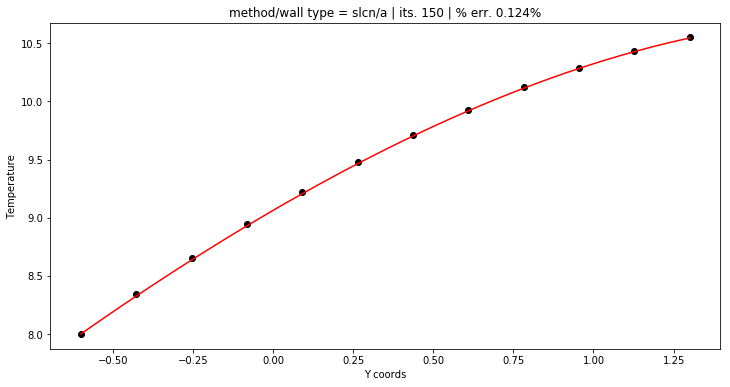

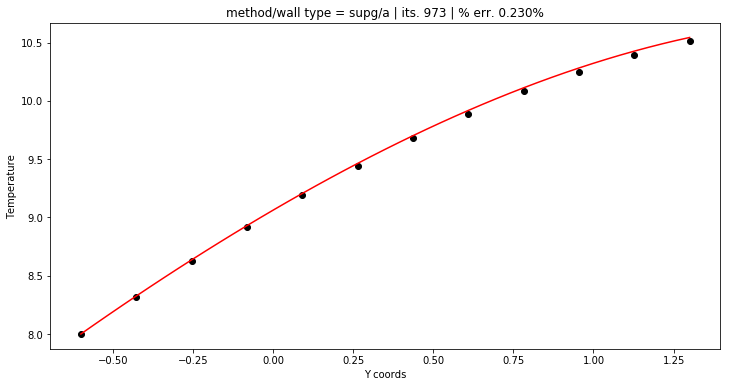

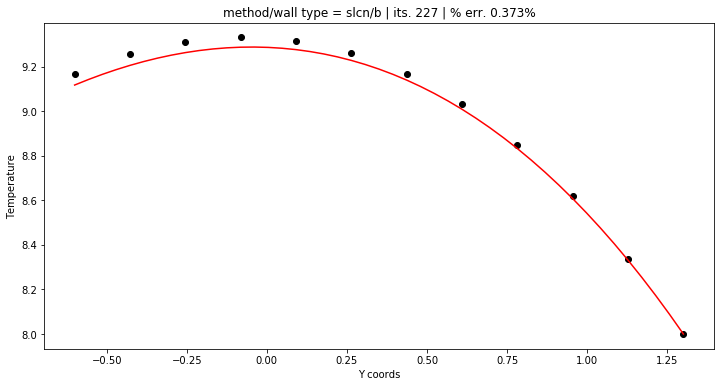

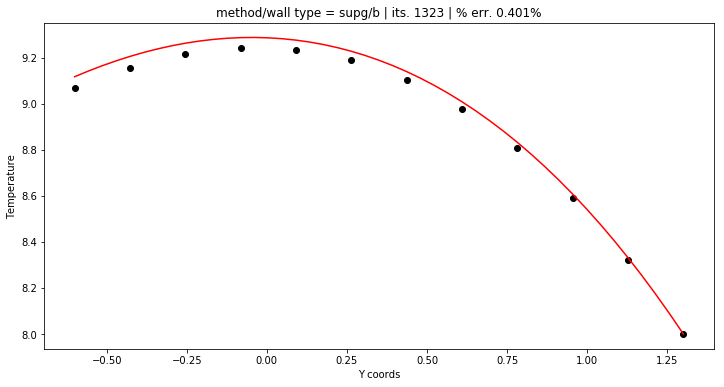

In [4]:
results = []
x = model_run(wall_setup='a',method_setup='slcn'); results.append(x)
x = model_run(wall_setup='a',method_setup='supg'); results.append(x)

x = model_run(wall_setup='b',method_setup='slcn'); results.append(x)
x = model_run(wall_setup='b',method_setup='supg'); results.append(x)

results = np.array(results)
# the second column is an integer but will be stored as float for simplicity

In [5]:
rank = uw.mpi.rank
if rank == 0:
    for exp in results:
        print("dt={:.2e}, timestep={}, per. error={:.3f}%".format(exp[0], int(exp[1]), exp[2]))
        
    threshold = 1.0 # 1% error theshold
    if np.any(results[:,2]>threshold):
        raise RuntimeError("The numerical solution is outside the error threshold {} of the analytic solution.".format(threshold))

dt=7.46e-03, timestep=150, per. error=0.124%
dt=7.46e-04, timestep=973, per. error=0.230%
dt=7.46e-03, timestep=227, per. error=0.373%
dt=7.46e-04, timestep=1323, per. error=0.401%


In [6]:
# Coefficients and setup for model without velocity
# v = 0.;
# h = 1.
# k = 2.
# phi = 2.

# ny = 1.
# c0 = (phi+h*y1)/k
# c1 = TD + h/(2.0*k)*y0**2 - c0*y0
# neumannIndex = mesh.specialSets['MaxJ_VertexSet']
# dirichletIndex = mesh.specialSets['MinJ_VertexSet']

# if wall_flux = 'bottom':
# ny = -1.
# c0 = (phi+h*y0)/k
# c1 = TD + h/(2.0*k)*y1**2 - c0*y1
# neumannIndex = mesh.specialSets['MinJ_VertexSet']
# dirichletIndex = mesh.specialSets['MaxJ_VertexSet']

# # analytic solution for NO velocity
# def analyticT(y):
#      return -h/(2*k)*y*y + c0*y + c1

# def analytic_dT_dy(y):
#     return -h/k*y + c0